In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from types import SimpleNamespace
import sys
sys.path.append('..')
from field_of_junctions import FieldOfJunctions
import matplotlib
import cv2

# Usage demo

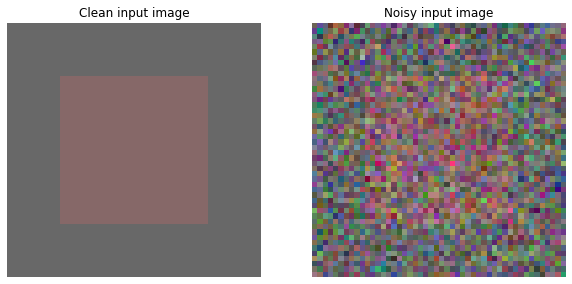

In [3]:
# Red square on black background
clean_img = np.zeros((48, 48, 3), dtype=np.float32)
clean_img[10:-10, 10:-10, 0] = 1.0

# Add noise
img = clean_img + np.random.randn(*clean_img.shape)
mn, mx = img.min(), img.max()

# Adjust contrast (equally to both images)
img = (img - mn) / (mx - mn)
clean_img = (clean_img - mn) / (mx - mn)

plt.figure(figsize=[10, 10])
plt.subplot(121)
plt.imshow(clean_img)
plt.title('Clean input image')
plt.axis('off');
plt.subplot(122)
plt.imshow(img)
plt.title('Noisy input image')
plt.axis('off');

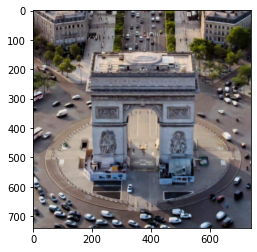

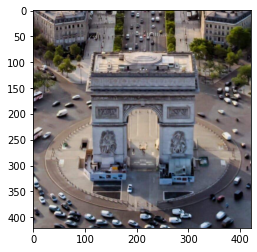

In [4]:
im_big = matplotlib.image.imread('Arch.jpeg')
R = 21
img = cv2.resize(im_big,(400+R,400+R))
plt.imshow(im_big)
plt.figure()
plt.imshow(img)
img.shape
img = np.asarray(img/255.0,dtype=np.float32)

Beginning initialization...
Initialization iteration 0/30


RuntimeError: CUDA out of memory. Tried to allocate 3.01 GiB (GPU 0; 8.00 GiB total capacity; 1.72 GiB already allocated; 2.52 GiB free; 4.08 GiB reserved in total by PyTorch)

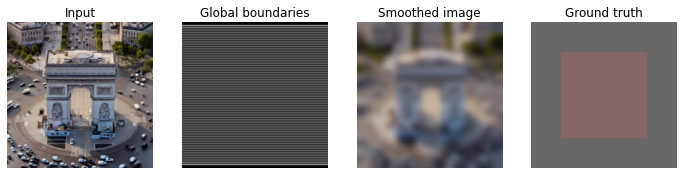

In [5]:
# Create opts object
opts = SimpleNamespace()

opts.R                        = 21
opts.stride                   = 5
opts.eta                      = 0.01
opts.delta                    = 0.05
opts.lr_angles                = 0.003
opts.lr_x0y0                  = 0.03
opts.lambda_boundary_final    = 0.5
opts.lambda_color_final       = 0.1
opts.nvals                    = 31
opts.num_initialization_iters = 30
opts.num_refinement_iters     = 1000
opts.greedy_step_every_iters  = 50
opts.parallel_mode            = True
opts.ang_per_vertex           = 3


# Define function for optimization (foj.optimize() may be used instead)
def foj_optimize_verbose():
    for i in range(foj.num_iters):
        if i == 0:
            print("Beginning initialization...")
        if i == opts.num_initialization_iters:
            print("Initialization done. Beginning refinement...")
        if i < opts.num_initialization_iters:
            if i % 5 == 0:
                print(f"Initialization iteration {i}/{opts.num_initialization_iters}")
        else:
            if i % 100 == 0:
                print(f"Refinement iteration {i}/{opts.num_refinement_iters}")
        foj.step(i)

# Create and optimize field of junctions
foj = FieldOfJunctions(img, opts)
%time foj_optimize_verbose()       # Run optimization with some printing

# Compute smoothed image and boundary map
params = torch.cat([foj.angles, foj.x0y0], dim=1)
dists, _, patches = foj.get_dists_and_patches(params)
local_boundaries = foj.dists2boundaries(dists)
global_boundaries = foj.local2global(local_boundaries)[0, 0, :, :].detach().cpu().numpy()
smoothed_img = foj.local2global(patches)[0, :, :, :].permute(1, 2, 0).detach().cpu().numpy()

plt.figure(figsize=[12, 12])
plt.subplot(141)
plt.imshow(img)
plt.title('Input')
plt.axis('off')
plt.subplot(142)
plt.imshow(global_boundaries, cmap='gray')
plt.title('Global boundaries')
plt.axis('off')
plt.subplot(143)
plt.imshow(smoothed_img)
plt.title('Smoothed image')
plt.axis('off')
plt.subplot(144)
plt.imshow(clean_img)
plt.title('Ground truth')
plt.axis('off');

# Field of junctions visualization demo

## First, visualize all `RxR` input patches

In [ ]:
from utils import patchstack

patch_vis = patchstack(foj.img_patches)[0, :, :, :].detach().permute(1, 2, 0).cpu().numpy()
plt.figure(figsize=[18, 18])
plt.imshow(patch_vis)
plt.title('Input patches')
plt.axis('off');

## Now visualize the local boundary maps obtained by the field of junctions in all patches

In [ ]:
boundary_vis = patchstack(local_boundaries)[0, :, :, :].detach().permute(1, 2, 0).cpu().numpy()
plt.figure(figsize=[18, 18])
plt.imshow(boundary_vis, cmap='gray')
plt.title('Local boundary maps')
plt.axis('off');

# Optimization visualization demo

In [6]:
# Using the exposed foj.step() function it is possible to create a visualization of the entire optimization
# process (here using the imageio package, but you can also use OpenCV's VideoWriter for example)
opts = SimpleNamespace()

opts.R                        = R
opts.stride                   = 10
opts.eta                      = 0.01
opts.delta                    = 0.05
opts.lr_angles                = 0.004
opts.lr_x0y0                  = 0.03
opts.lambda_boundary_final    = 0.6
opts.lambda_color_final       = 0.1
opts.nvals                    = 31
opts.num_initialization_iters = 40
opts.num_refinement_iters     = 2000
opts.greedy_step_every_iters  = 30
opts.parallel_mode            = True
opts.ang_per_vertex           = 3


import imageio

def foj_optimize_visualize_optimization():
    with imageio.get_writer('ArchBoundaries_R21_2000iters.mp4', fps=60, quality=9) as writer:
        for i in range(foj.num_iters):
            if i == 0:
                print("Beginning initialization...")
            if i == opts.num_initialization_iters:
                print("Initialization done. Beginning refinement...")
            if i < opts.num_initialization_iters:
                if i % 5 == 0:
                    print(f"Initialization iteration {i}/{opts.num_initialization_iters}")
            else:
                if i % 100 == 0:
                    print(f"Refinement iteration {i}/{opts.num_refinement_iters}")
            foj.step(i)
            
            # Compute smoothed image and boundaries
#             params = torch.cat([foj.angles, foj.x0y0], dim=1)
#             dists, _, patches = foj.get_dists_and_patches(params)
#             local_boundaries = foj.dists2boundaries(dists)
#             global_boundaries = foj.local2global(local_boundaries)[0, 0, :, :].detach().cpu().numpy()[:, :, np.newaxis]
#             smoothed_img = foj.local2global(patches)[0, :, :, :].permute(1, 2, 0).detach().cpu().numpy()

            #FOR COLOR IMAGE
            params = torch.cat([foj.angles, foj.x0y0], dim=1)
            dists, _, patches = foj.get_dists_and_patches(params)
            local_boundaries = foj.dists2boundaries(dists)
            global_boundaries = foj.local2global(local_boundaries)[0, 0, :, :].detach().cpu().numpy()[:, :, np.newaxis].repeat(3, 2)
            smoothed_img = foj.local2global(patches)[0, :, :, :].permute(1, 2, 0).detach().cpu().numpy()
            output = np.concatenate([img, smoothed_img, global_boundaries], axis=1)
                        
            writer.append_data(np.uint8(255.0 * output))
    return img, smoothed_img, global_boundaries

# Create and optimize field of junctions
foj = FieldOfJunctions(img, opts)
i1,i2,i3 = foj_optimize_visualize_optimization()



Beginning initialization...
Initialization iteration 0/40


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1263, 421) to (1264, 432) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Initialization iteration 5/40
Initialization iteration 10/40
Initialization iteration 15/40
Initialization iteration 20/40
Initialization iteration 25/40
Initialization iteration 30/40
Initialization iteration 35/40
Initialization done. Beginning refinement...
Refinement iteration 100/2000
Refinement iteration 200/2000
Refinement iteration 300/2000
Refinement iteration 400/2000
Refinement iteration 500/2000
Refinement iteration 600/2000
Refinement iteration 700/2000
Refinement iteration 800/2000
Refinement iteration 900/2000
Refinement iteration 1000/2000
Refinement iteration 1100/2000
Refinement iteration 1200/2000
Refinement iteration 1300/2000
Refinement iteration 1400/2000
Refinement iteration 1500/2000
Refinement iteration 1600/2000
Refinement iteration 1700/2000
Refinement iteration 1800/2000
Refinement iteration 1900/2000
Refinement iteration 2000/2000


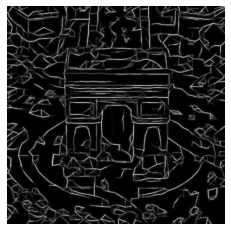

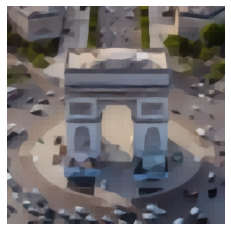

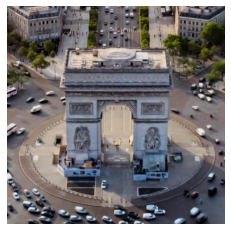

In [12]:
plt.imshow(i3)
plt.axis('off')

plt.savefig('ArcBoundaries.png')
plt.figure()
plt.imshow(i2)
plt.axis('off')
plt.savefig('ArcSmoothImages.png')
plt.figure()
plt.imshow(i1)
plt.axis('off')
plt.savefig('ArcImage.png')